# Dogs vs Cat classifier

This notebook creates a model using the training data provided by ASSIRA and uses the trained model to classify unlabelled data

The steps followed in this notebook is as follows:

1. Importing Required modules
2. Configure training Configurations
3. Allocate data and check configurations
4. Checking the contents of training dataset
5. Image Augmentation examples
6. Prepare training and validation data
7. Simple model creation and compiling
8. Training the model
9. Plotting the results
10. Using the model to predict test data


### 1. Importing Required modules:

The essential modules required for running this notebook are:

```
Keras 2.2.4
TensorFlow 2.1.0
Numpy 1.16.4
Pandas 0.25.1
```

In [71]:
import os
import time
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image

%matplotlib inline
print('Keras', keras.__version__)
print('TensorFlow', tf.__version__)
print('Numpy', np.__version__)
print('Pandas', pd.__version__)

Keras 2.2.4
TensorFlow 2.1.0
Numpy 1.16.4
Pandas 0.25.1


### 2. Configuration

Configure epocs, batch size and no fo samples to adjust according to the preferrence

In [72]:
train_samples      = 2000
validation_samples = 1000

target_size    = (150,150) #size of the image in pixels
batch_size     = 16
epochs         = 60
model_filepath = 'dog_cat_simple_model_7thfeb_100_epocs.h5'


train_dir      = 'ASSIRA/train'
validation_dir = 'ASSIRA/validation'
test_dir = "ASSIRA/testing"

### 3. Data Allocation and testing the configurations:

Uses a dataset with following directory structure and files in them
```
/train
    /cat    (1000 images) labelled
    /dog    (1000 images) labelled
/validation
    /cat    (500 images) labelled
    /dog    (500 images) labelled
/testing    (1000 images) unlabelled 
```

the dataset used is hosted as ASSIRA4000divided at https://www.kaggle.com/kasudy/assira4000divided
This is quite fast to load in google colab

unzip the ASSIRA.zip which will take a while in local machine

In [85]:
try: 
    print("The model will be saved as : " + model_filepath)
    print("batch-size                 :", batch_size)
    print("epochs                     :", epochs)
    print("train_samples              :", train_samples)
    print("validation_samples         :", validation_samples)
    print("train for                  :", train_samples // batch_size," steps")
    print("validate for               :", validation_samples // batch_size," steps")
    print("\n=======================================================\n")
    print("Training directory with images of dogs    : ",len(os.listdir(train_dir+'/dog'))," <<Labelled>>")
    print("Training directory with images of cats    : ",len(os.listdir(train_dir+'/cat'))," <<Labelled>>")
    print("Validation directory with images of dogs  : ",len(os.listdir(validation_dir+'/dog'))," <<Labelled>>")
    print("Validation directory with images of cats  : ",len(os.listdir(validation_dir+'/cat'))," <<Labelled>>")
    print("Test directory with images of cats/dogs   : ",len(os.listdir(test_dir))," <<UNLABELLED>>")
except:
    print("\n=======================================================\n")
    print("Error! please make sure you have the data please unzip and re-run this cell")

The model will be saved as : dog_cat_simple_model_7thfeb_100_epocs.h5
batch-size                 : 16
epochs                     : 60
train_samples              : 2000
validation_samples         : 1000
train for                  : 125  steps
validate for               : 62  steps


Training directory with images of dogs    :  1000  <<Labelled>>
Training directory with images of cats    :  1000  <<Labelled>>
Validation directory with images of dogs  :  500  <<Labelled>>
Validation directory with images of cats  :  500  <<Labelled>>
Test directory with images of cats/dogs   :  1000  <<UNLABELLED>>


In [74]:
# !unzip ASSIRA.zip

### 4. Checking the contents of the training dataset

Checking 6 images of both cats and dogs

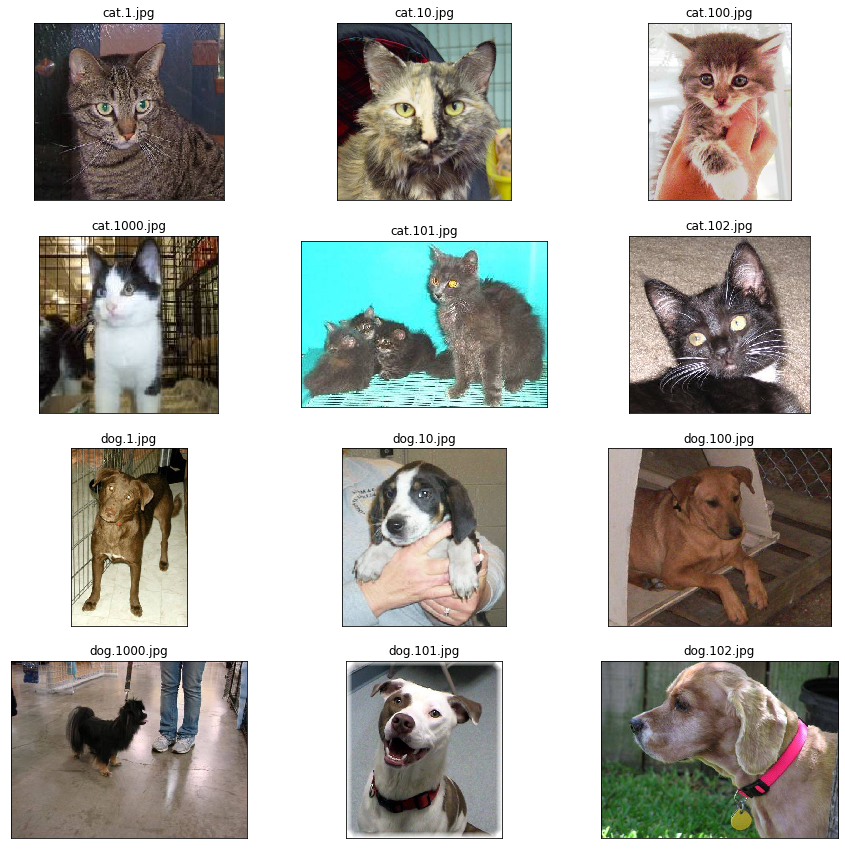

In [75]:
files = [[path+f for f in os.listdir(path)[:6]] for path in [f'ASSIRA/train/{x}/' for x in ['cat', 'dog']]]

fig, axs = plt.subplots(4, 3, figsize=(15,15), subplot_kw={'xticks': [], 'yticks': []})

for ax, img in zip(axs.flatten(), [item for sublist in files for item in sublist]):
    ax.imshow(load_img(img))
    ax.set_title(img.split('/')[-1])

### 5. Image Augmentation examples

Image augmentation is a useful trick that can increase the data amount by doing various transformation. This is quite helpful when working with less data.

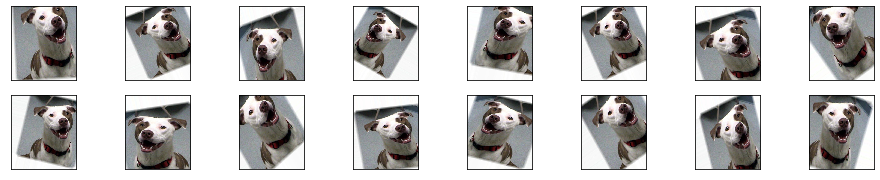

In [81]:
# define image transformations
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img_samples = 16
image_dir = 'preview/'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

img = load_img('ASSIRA/train/dog/dog.101.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

from itertools import islice
list(islice(datagen.flow(x, 
                         batch_size=1, 
                         save_to_dir=image_dir, 
                         save_prefix='cat', 
                         save_format='jpeg'), 
                         img_samples));

rows, cols = 2, img_samples // 2
fig, axs = plt.subplots(rows, cols, figsize=(16,3), subplot_kw={'xticks': [], 'yticks': []})

for ax, img in zip(axs.flatten(), os.listdir(image_dir)[:img_samples]):
    ax.imshow(load_img(image_dir+img))

### 6. Prepare training and validation data

Augment training data but ignore augmentation on validation data as it is not necessary

In [79]:
# rescale and augment training data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# rescale validation data
validation_datagen = ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 7. Simple model creation and compiling


Using a simple CNN model with 6 Convolution layer and 3 pooling layer. Then Compiling the model

In [86]:
input_tensor = Input(shape=(150,150,3))

model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape=(150,150,3), activation='relu'))
model.add(Conv2D(128, (3, 3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 148, 148, 128)     3584      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 146, 146, 128)     147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 73, 73, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 71, 71, 32)        36896     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 69, 69, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 64)       

### 8. Training the model

Training the designed model using the training and validation data. The configurations will be according to the configurations set before

In [80]:
history = model.fit_generator(
                train_generator,
                steps_per_epoch=train_samples // batch_size,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=validation_samples // batch_size)

model.save(model_filepath)
print("model saved")

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 125 steps, validate for 62 steps
Epoch 1/60
125/125 [==============================] - 34s 271ms/step - loss: 0.7100 - accuracy: 0.4920 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/60
125/125 [==============================] - 24s 189ms/step - loss: 0.6983 - accuracy: 0.4925 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 3/60
125/125 [==============================] - 23s 187ms/step - loss: 0.6956 - accuracy: 0.4835 - val_loss: 0.6908 - val_accuracy: 0.5020
Epoch 4/60
125/125 [==============================] - 24s 188ms/step - loss: 0.6983 - accuracy: 0.5080 - val_loss: 0.6968 - val_accuracy: 0.5060
Epoch 5/60
125/125 [==============================] - 24s 191ms/step - loss: 0.7035 - accuracy: 0.5085 - val_loss: 0.7358 - val_accuracy: 0.5081
Epoch 6/60
125/125 [==============================] - 24s 190ms/step - loss: 0.7004 - accuracy: 0.5185 - val_loss: 0.6881 - val_accuracy: 0.5413
Epoch 7/60
125/125 [=================

Epoch 56/60
125/125 [==============================] - 24s 194ms/step - loss: 0.2973 - accuracy: 0.8770 - val_loss: 0.5665 - val_accuracy: 0.7863
Epoch 57/60
125/125 [==============================] - 24s 195ms/step - loss: 0.3114 - accuracy: 0.8760 - val_loss: 0.6504 - val_accuracy: 0.7772
Epoch 58/60
125/125 [==============================] - 25s 196ms/step - loss: 0.3079 - accuracy: 0.8785 - val_loss: 0.9215 - val_accuracy: 0.7550
Epoch 59/60
125/125 [==============================] - 27s 218ms/step - loss: 0.3197 - accuracy: 0.8680 - val_loss: 0.6634 - val_accuracy: 0.7782
Epoch 60/60
125/125 [==============================] - 24s 192ms/step - loss: 0.2697 - accuracy: 0.8930 - val_loss: 0.6230 - val_accuracy: 0.7964
model saved


### 9. Plotting the results

plotting the accuracy and validation accuracy of the trained model using matplotlib

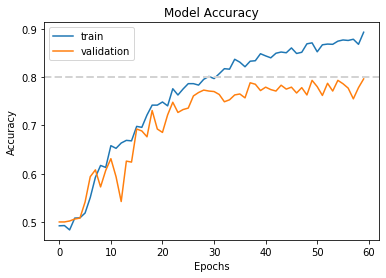

In [95]:
try: #for tensorflow 1
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
except: #for tensorflow 2
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.axhline(y=0.8, linewidth=2, linestyle='dashed', color='lightgrey')
plt.show()


### 10. Using the model to predict test data

loading the saved model and then predicting 19 test data using the trained model

In [97]:
loaded_model = tf.keras.models.load_model(model_filepath)
loaded_model.layers[0].input_shape

(None, 150, 150, 3)

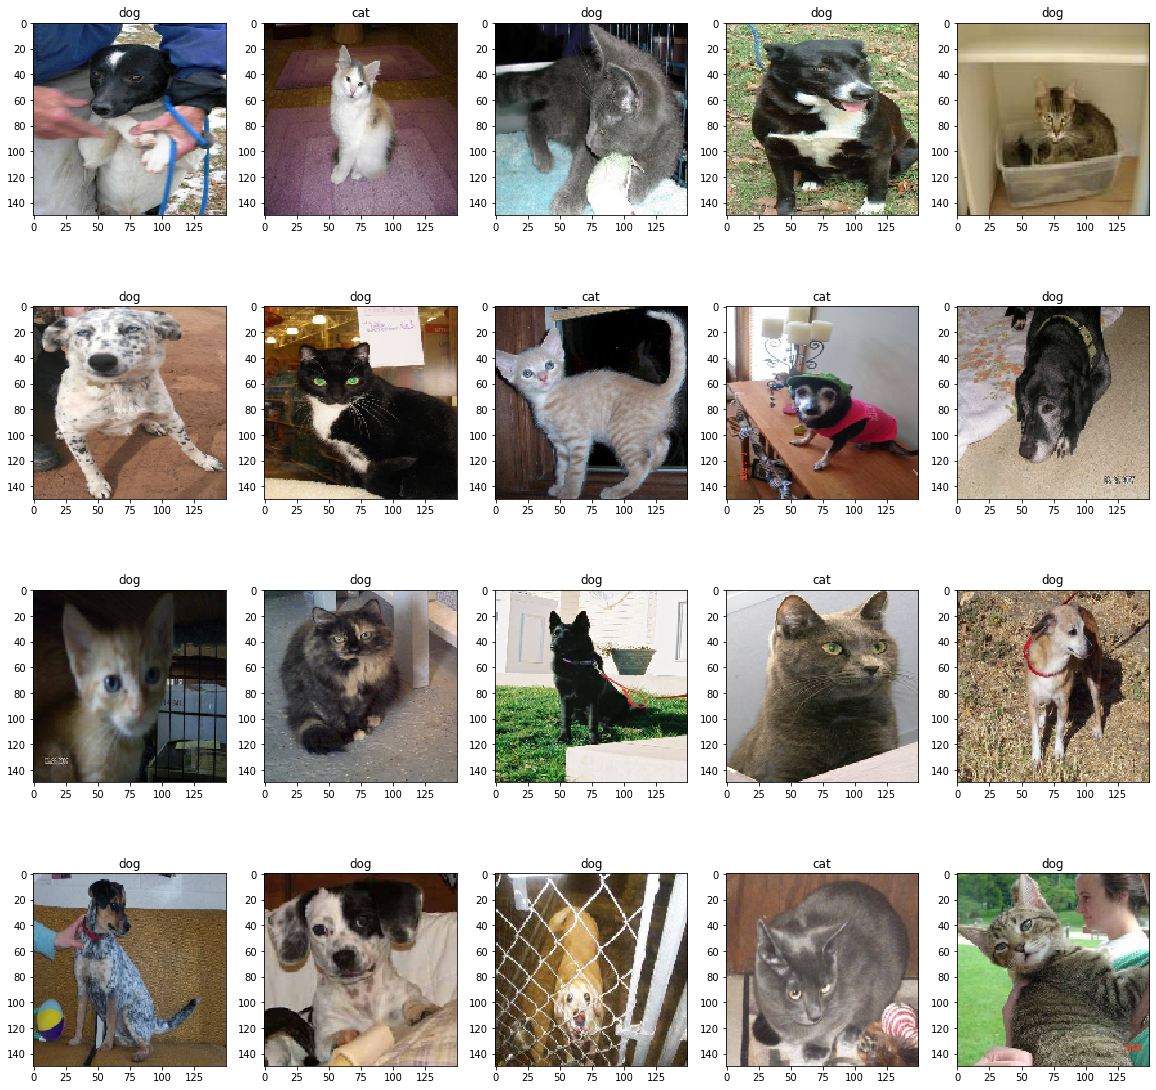

In [98]:
batch_holder = np.zeros((20, 150, 150, 3))
img_dir='ASSIRA/testing/'
for i,img in enumerate(os.listdir(img_dir)):
    if i > 19:
        break
    img = image.load_img(os.path.join(img_dir,img), target_size=(150,150))
    batch_holder[i, :] = img

def get_label_name(num):
    if num == 1:
        return "dog"
    else:
        return "cat"

result=loaded_model.predict_classes(batch_holder)
fig = plt.figure(figsize=(20, 20))
 
for i,img in enumerate(batch_holder):
  fig.add_subplot(4,5, i+1)
  plt.title(get_label_name(result[i][0]))
  plt.imshow(img/256.)
  
plt.show()

In [93]:
dog_cat_simple_model_7thfeb_60_epocs_acc = [[0.492, 0.4925, 0.4835, 0.508, 0.5085, 0.5185, 0.5505, 0.5925, 0.617, 0.613, 0.658, 0.6525, 0.6635, 0.669, 0.668, 0.698, 0.696, 0.7215, 0.742, 0.742, 0.7485, 0.7405, 0.776, 0.763, 0.7755, 0.7865, 0.7865, 0.7835, 0.7955, 0.8015, 0.797, 0.807, 0.8175, 0.8165, 0.837, 0.831, 0.8215, 0.833, 0.834, 0.8485, 0.844, 0.84, 0.8495, 0.852, 0.8505, 0.8605, 0.849, 0.8515, 0.869, 0.871, 0.8525, 0.867, 0.8685, 0.868, 0.8745, 0.877, 0.876, 0.8785, 0.868, 0.893],
[0.5, 0.5, 0.5020161, 0.5060484, 0.5080645, 0.54133064, 0.59375, 0.6078629, 0.57258064, 0.60685486, 0.6310484, 0.59375, 0.5423387, 0.6260081, 0.6239919, 0.69254035, 0.6885081, 0.6764113, 0.73084676, 0.69254035, 0.6854839, 0.7217742, 0.7479839, 0.7268145, 0.7328629, 0.7358871, 0.7610887, 0.76814514, 0.7731855, 0.77116936, 0.7701613, 0.7641129, 0.7489919, 0.7530242, 0.76310486, 0.765121, 0.7570565, 0.7883065, 0.78528225, 0.7721774, 0.7792339, 0.7741935, 0.77116936, 0.7832661, 0.7752016, 0.7792339, 0.7671371, 0.7782258, 0.76310486, 0.79334676, 0.7802419, 0.76209676, 0.7872984, 0.77116936, 0.79334676, 0.78629035, 0.77721775, 0.75504035, 0.7782258, 0.796371]]

In [99]:
def predict(input_image):
    custom_image = np.zeros((1, 150, 150, 3))
    img = image.load_img(input_image, target_size=(150,150))
    custom_image[0, :] = img

    def get_label_name(num):
        if num == 1:
            return "dog"
        else:
            return "cat"
        
    result=loaded_model.predict_classes(custom_image)
    fig = plt.figure(figsize=(20, 20))

    for i,img in enumerate(custom_image):
      fig.add_subplot(4,5, i+1)
      plt.title(get_label_name(result[i][0]))
      plt.imshow(img/256.)
    plt.show()

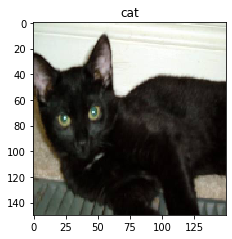

In [100]:
predict("ASSIRA/testing/117.jpg")

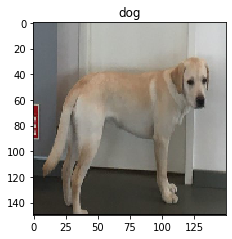

In [101]:
predict("m.jpg")

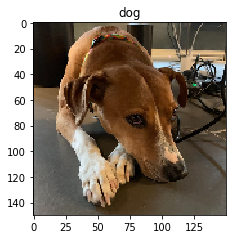

In [102]:
predict("x.jpg")